## Documento para debug visual do código, visando entender o processo

Código:

alphaVec = [0.1,0.5,1]


sigmaVec = [0,20,80]


salt     =  0.0015


rocDict = {}


runs = 5


wmax = 80


nn = 1


for k in tqdm(range(len(alphaVec))):


    alpha = alphaVec[k]
    
    
    for j in tqdm(range(len(sigmaVec))):
    
    
        sigma = sigmaVec[j]

        for contrast in ["cygnus"]:
            if(contrast == "int"):
                param = 2
            elif(contrast == "beta"):
                param = 4.7
            elif(contrast == "cygnus"):
                param = [20,salt,sigma,alpha]    
            else:
                param = 0
            for method in ["none"]:
        
                for nRuns in range(0,runs):
                    n = nRuns
                    name     =  '../data_sim/teste_' + str(n) + '_'+ str(nn)
                    img      =  cv2.imread( name +'.png',cv2.IMREAD_GRAYSCALE)
                    imgTruth =  img.copy()
                    img      =  functions.contrastReduce(alpha,imgTruth)
                    imNoisy  =  functions.noisy("salt",salt,img)
                    imNoisy  =  functions.noisy("gaussian",sigma**2,imNoisy)
                    imCont   =  functions.contrastAnalise(imNoisy,contrast,param)
                    result   = functions.imageFilter(imCont,method,imgTruth,wmax)
                    result   =  functions.imgCompare(imCont,imgTruth)
                    del n,name,img,imgTruth,imNoisy,imCont
                    if(nRuns>=1):
                        sp    = np.append(sp,result[0])
                        index = np.append(index,result[1])
                    else:    
                        sp       = result[0]
                        index    = result[1]
                rocDict[contrast+"alpha = "+str(alpha)+"_sigma = "+str(sigma)+"_"+method] = [sp,index]
            #rocDict[contrast+"alpha = "+str(alpha)+"_sigma = "+str(sigma)] = [sp,index]

functions.saveData(rocDict,"contrast_filter_50runs") 

### Parte 1: Redução de contraste
 

In [2]:
import numpy as np
import cv2 
from tqdm import tqdm
import functions
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

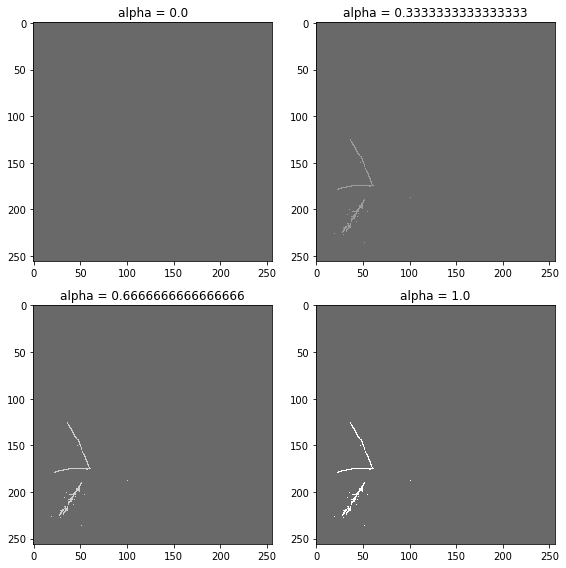

In [5]:
nn          =  1                                                   ## numero da imagem
n           =  5                                                   ## numero da imagem
name        =  '../data_sim/teste_' + str(n) + '_'+ str(nn)        ## nome do arquivo
img         =  cv2.imread( name +'.png',cv2.IMREAD_GRAYSCALE)      ## le imagem
imgTruth    =  img.copy()                                          ## copia imagem original
nrows       =  2
ncols       =  2
fig,axes    = plt.subplots(nrows,ncols,figsize=(8,8))
alphaRange  = np.linspace(0,1,nrows*ncols,endpoint=True)
for alpha,ax in zip(alphaRange,axes.ravel()):
    img     =  functions.contrastReduce(alpha,imgTruth)        ## altera contraste
    ax.imshow(img,cmap= "gray",vmin=0,vmax=255)
    ax.set_title("alpha = " + str(alpha))
fig.tight_layout()    


Com as imagens acima é possível observar que a função de redução de contraste esta apresentando o comportamento esperado. Agora o próximo passo é verificar a função que inseri ruído na imagem.

### Parte 2: Adição de ruído
#### salt and pepper

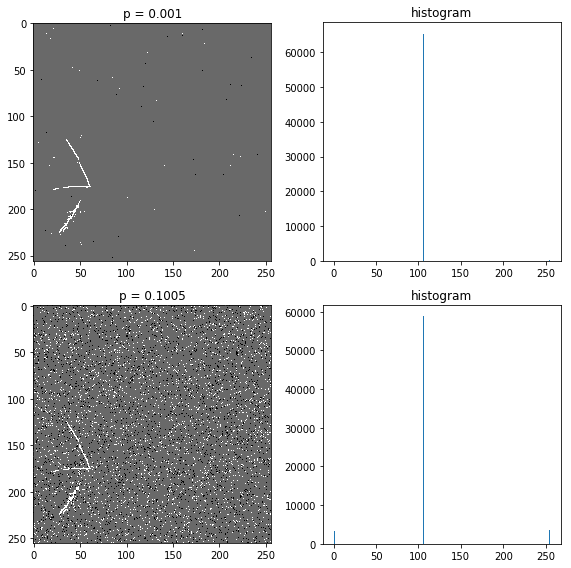

In [6]:
nrows       =  2
ncols       =  2
fig,axes    = plt.subplots(nrows,ncols,figsize=(8,8))
for p,ax in zip(np.linspace(0.001,0.2,3),axes):
    img      =  cv2.imread( name +'.png',cv2.IMREAD_GRAYSCALE)      ## le imagem
    imgTruth =  img.copy()                                          ## copia imagem original
    imNoisy  =  functions.noisy("salt",p,imgTruth)
    ax[0].imshow(imNoisy,cmap= "gray",vmin=0,vmax=255)
    ax[0].set_title("p = " + str(p))
    ax[1].hist(imNoisy.ravel(),bins = int(np.sqrt(len(imNoisy.ravel()))))
    ax[1].set_title('histogram')
fig.tight_layout()    

#### Gaussiano

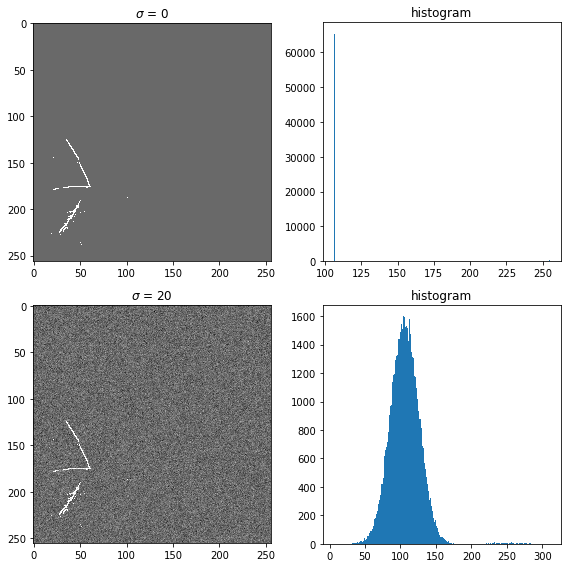

In [7]:
nrows       =  2
ncols       =  2
fig,axes    = plt.subplots(nrows,ncols,figsize=(8,8))
for sigma,ax in zip([0,20,80],axes):
    img      =  cv2.imread( name +'.png',cv2.IMREAD_GRAYSCALE)      ## le imagem
    imgTruth =  img.copy()                                          ## copia imagem original
    imNoisy  =  functions.noisy("gaussian",sigma**2,imgTruth)
    ax[0].imshow(imNoisy,cmap= "gray",vmin=0,vmax=255)
    ax[0].set_title("$\sigma$ = " + str(sigma))
    ax[1].hist(imNoisy.ravel(),bins = int(np.sqrt(len(imNoisy.ravel()))))
    ax[1].set_title('histogram')
fig.tight_layout()  

Com as imagens acima é possível observar que a função de redução de contraste esta apresentando o comportamento esperado. Agora o próximo passo é verificar o desempenho dos filtros nas imagens

### Parte 2: Filtragem


#### Análise com filtro
##### Filtro de Média: 

Primeiro vamos observar o comportamento deste filtro para baixo contraste($\alpha$ pequeno) e depois para alto contraste($\alpha$ = 1).

Abaixo exibimos uma imagem com ruido gaussiano de desvio 20 e contraste muito baixo($\alpha = 0.2$).

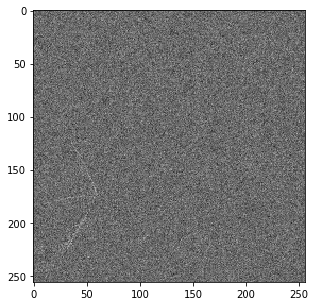

In [8]:
alpha    =  0.2
sigma    =  20
salt     =  0
name     =  '../data_sim/teste_' + str(n) + '_'+ str(nn)        ## nome do arquivo
img      =  cv2.imread( name +'.png',cv2.IMREAD_GRAYSCALE)      ## le imagem
imgTruth =  img.copy()                                          ## copia imagem original
img      =  functions.contrastReduce(alpha,imgTruth)
imNoisy  =  functions.noisy("salt",salt,img)
imNoisy  =  functions.noisy("gaussian",sigma**2,imNoisy)

plt.figure(figsize=(5,5))
plt.imshow(imNoisy,cmap = "gray",vmin = 0,vmax = 255)

In [10]:
bgDesired   =  0.99

### Iremos avaliar o desempenho do filtro de media variando o tamanho de sua janela

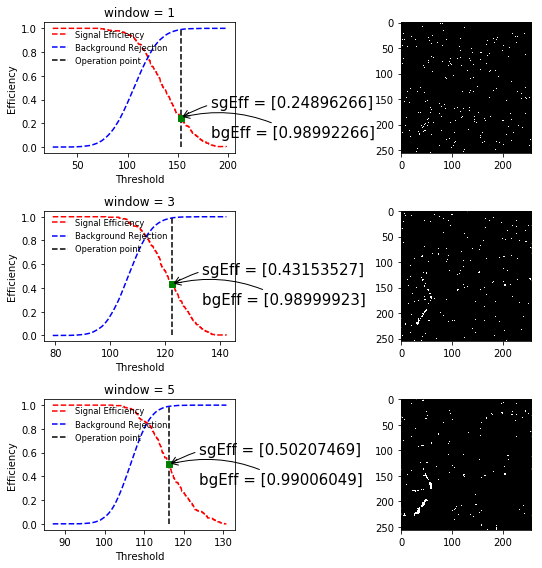

In [14]:
## verificar se salt = 0 !!!
windowRange =  np.arange(1,7,2)
nrows       =  len(windowRange)
ncols       =  2
fig,axes    = plt.subplots(nrows,ncols,figsize=(8,8))
sg          =  np.zeros(windowRange.shape)
i           =  0
for window,ax in zip(windowRange,axes):
    imEnhanced  =  cv2.blur(imNoisy,(window,window))
    xRange      =  np.linspace(imEnhanced.min(),imEnhanced.max(),1000)
    sgEff,bgEff =  functions.getRoc(imgTruth,imEnhanced,xRange)
    bestIndBg   =  abs(bgEff-bgDesired).argmin()
    sg[i]       =  sgEff[bestIndBg]
    i           += 1
    ##plots
    ax[0].plot(xRange,sgEff,'r--',linewidth = 1.5,label = 'Signal Efficiency')
    ax[0].plot(xRange,bgEff,'b--',linewidth = 1.5,label = 'Background Rejection')
    ax[0].plot([xRange[bestIndBg],xRange[bestIndBg]],[0,max(sgEff[bestIndBg],bgEff[bestIndBg])],'k--',label = 'Operation point')
    ax[0].plot(xRange[bestIndBg],sgEff[bestIndBg],'gs')
    ax[0].legend(loc = 'upper left',frameon = False,fontsize = 'small')
    ax[0].set_xlabel('Threshold')
    ax[0].set_ylabel('Efficiency')
    ax[0].set_title('window = '+str(window))
    ax[0].annotate('sgEff = '+str(sgEff[bestIndBg]),
             xy=(xRange[bestIndBg],sgEff[bestIndBg]), xycoords='data',
             xytext=(+30, +10), textcoords='offset points', fontsize=15,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    
    ax[0].annotate('bgEff = '+str(bgEff[bestIndBg]),
             xy=(xRange[bestIndBg],sgEff[bestIndBg]), xycoords='data',
             xytext=(+30, -20), textcoords='offset points', fontsize=15,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    
    ax[1].imshow(imEnhanced>xRange[bestIndBg],cmap = 'gray')
fig.tight_layout()  

### Testando o desempenho de um filtro gaussiano

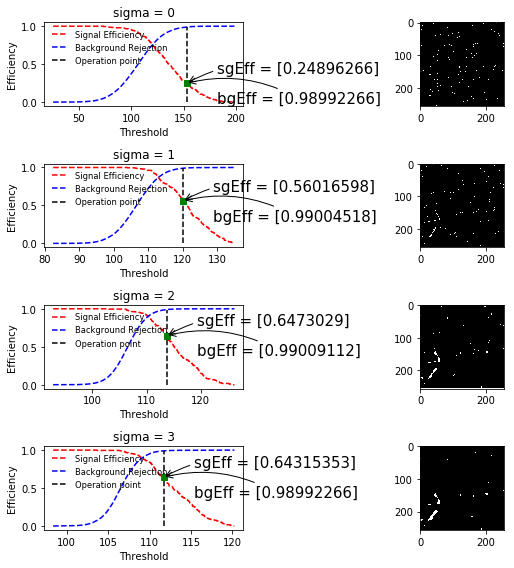

In [17]:
from scipy.ndimage import gaussian_filter
sigma       =  np.arange(0,4,1)
nrows       =  len(sigma)
ncols       =  2
fig,axes    = plt.subplots(nrows,ncols,figsize=(8,8))
sg          =  np.zeros(sigma.shape)
i           =  0
for window,ax in zip(sigma,axes):
    imEnhanced  =  gaussian_filter(imNoisy,window)
    xRange      =  np.linspace(imEnhanced.min(),imEnhanced.max(),1000)
    sgEff,bgEff =  functions.getRoc(imgTruth,imEnhanced,xRange)
    #f           =  interp1d(sgEff,bgEff)
    bestIndBg   =  abs(bgEff-bgDesired).argmin()
    sg[i]       =  sgEff[bestIndBg]
    #sg[i]       =  f(bgDesired)
    i           += 1
    ##plots
    ax[0].plot(xRange,sgEff,'r--',linewidth = 1.5,label = 'Signal Efficiency')
    ax[0].plot(xRange,bgEff,'b--',linewidth = 1.5,label = 'Background Rejection')
    ax[0].plot([xRange[bestIndBg],xRange[bestIndBg]],[0,max(sgEff[bestIndBg],bgEff[bestIndBg])],'k--',label = 'Operation point')
    ax[0].plot(xRange[bestIndBg],sgEff[bestIndBg],'gs')
    
    #ax[0].plot([xRange[bestIndBg],xRange[bestIndBg]],[0,max(f(bgDesired),bgDesired)],'k--',label = 'Operation point')
    #ax[0].plot(xRange[bestIndBg],f(bgDesired),'gs')
    
    ax[0].legend(loc = 'upper left',frameon = False,fontsize = 'small')
    ax[0].set_xlabel('Threshold')
    ax[0].set_ylabel('Efficiency')
    ax[0].annotate('sgEff = '+str(sgEff[bestIndBg]),
             xy=(xRange[bestIndBg],sgEff[bestIndBg]), xycoords='data',
             xytext=(+30, +10), textcoords='offset points', fontsize=15,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    
    ax[0].annotate('bgEff = '+str(bgEff[bestIndBg]),
             xy=(xRange[bestIndBg],sgEff[bestIndBg]), xycoords='data',
             xytext=(+30, -20), textcoords='offset points', fontsize=15,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    
    ax[0].set_title('sigma = '+str(window))
    ax[1].imshow(imEnhanced>xRange[bestIndBg],cmap = 'gray')
fig.tight_layout()  





### O que e feito no cygnus

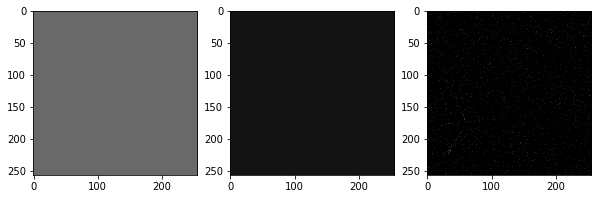

In [18]:
mean     = 106
std     = 20
imMean = mean*np.ones(img.shape)
imStd = std*np.ones(img.shape)
fig,axes =    plt.subplots(1,3,figsize=(10,10))
axes[0].imshow(imMean,cmap = "gray",vmin = 0,vmax = 255)
axes[1].imshow(imStd,cmap = "gray",vmin = 0,vmax = 255)
axes[2].imshow(imNoisy-(imMean+imStd),cmap = "gray",vmin = 0,vmax = 255)

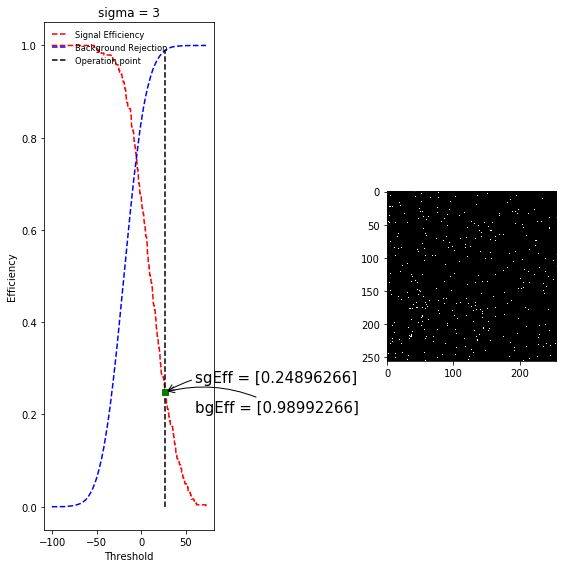

In [21]:
fig,ax =    plt.subplots(1,2,figsize=(8,8))
imEnhanced     =imNoisy-(imMean+imStd)
xRange      =  np.linspace(imEnhanced.min(),imEnhanced.max(),1000)
sgEff,bgEff =  functions.getRoc(imgTruth,imEnhanced,xRange)
bestIndBg   =  abs(bgEff-bgDesired).argmin()
ax[0].plot(xRange,sgEff,'r--',linewidth = 1.5,label = 'Signal Efficiency')
ax[0].plot(xRange,bgEff,'b--',linewidth = 1.5,label = 'Background Rejection')
ax[0].plot([xRange[bestIndBg],xRange[bestIndBg]],[0,max(sgEff[bestIndBg],bgEff[bestIndBg])],'k--',label = 'Operation point')
ax[0].plot(xRange[bestIndBg],sgEff[bestIndBg],'gs')
ax[0].legend(loc = 'upper left',frameon = False,fontsize = 'small')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Efficiency')
ax[0].annotate('sgEff = '+str(sgEff[bestIndBg]),
             xy=(xRange[bestIndBg],sgEff[bestIndBg]), xycoords='data',
             xytext=(+30, +10), textcoords='offset points', fontsize=15,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    
ax[0].annotate('bgEff = '+str(bgEff[bestIndBg]),
             xy=(xRange[bestIndBg],sgEff[bestIndBg]), xycoords='data',
             xytext=(+30, -20), textcoords='offset points', fontsize=15,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    
ax[0].set_title('sigma = '+str(window))
ax[1].imshow(imEnhanced>xRange[bestIndBg],cmap = 'gray')
fig.tight_layout()  

### Pode-se repetir as etapas acima com imagens do cygnus

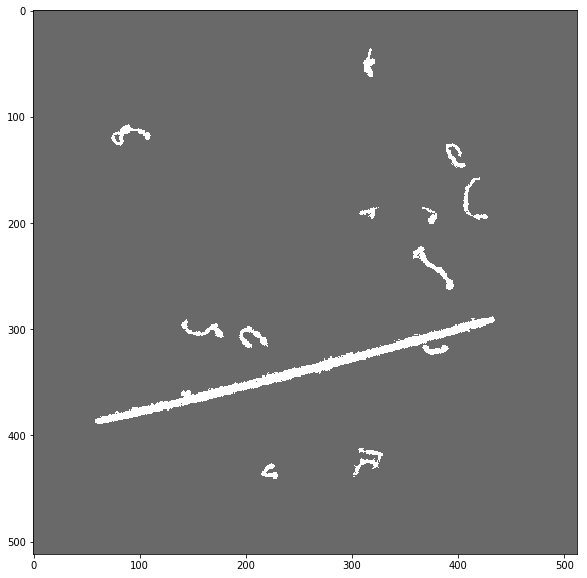

In [22]:
alpha    =  0.1
sigma    =  20
salt     =  0
name     =  '../data_sim/teste_' + str(0) + '_'+ str(0)        ## nome do arquivo
img      =  cv2.imread( name +'.png',cv2.IMREAD_GRAYSCALE)      ## le imagem
img[img==5] = 106
img[img==237] = 255
imgTruth =  img.copy()                                          ## copia imagem original
#img      =  functions.contrastReduce(alpha,imgTruth)
#imNoisy  =  functions.noisy("salt",salt,img)
#imNoisy  =  functions.noisy("gaussian",sigma**2,imNoisy)

plt.figure(figsize=(10,10))
plt.imshow(img,cmap = "gray",vmin = 0,vmax = 255)


### Filtro de média

### Filtro gaussiano

In [ ]:
from scipy.ndimage import gaussian_filter
sigma       =  np.arange(0,7,1)
nrows       =  len(sigma)
ncols       =  2
fig,axes    = plt.subplots(nrows,ncols,figsize=(20,20))
sg          =  np.zeros(windowRange.shape)
i           =  0
for window,ax in zip(sigma,axes):
    imEnhanced  =  gaussian_filter(imNoisy,window)
    xRange      =  np.linspace(imEnhanced.min(),imEnhanced.max(),1000)
    sgEff,bgEff =  functions.getRoc(imgTruth,imEnhanced,xRange)
    #f           =  interp1d(sgEff,bgEff)
    bestIndBg   =  abs(bgEff-bgDesired).argmin()
    sg[i]       =  sgEff[bestIndBg]
    #sg[i]       =  f(bgDesired)
    i           += 1
    ##plots
    ax[0].plot(xRange,sgEff,'r--',linewidth = 1.5,label = 'Signal Efficiency')
    ax[0].plot(xRange,bgEff,'b--',linewidth = 1.5,label = 'Background Rejection')
    ax[0].plot([xRange[bestIndBg],xRange[bestIndBg]],[0,max(sgEff[bestIndBg],bgEff[bestIndBg])],'k--',label = 'Operation point')
    ax[0].plot(xRange[bestIndBg],sgEff[bestIndBg],'gs')
    
    #ax[0].plot([xRange[bestIndBg],xRange[bestIndBg]],[0,max(f(bgDesired),bgDesired)],'k--',label = 'Operation point')
    #ax[0].plot(xRange[bestIndBg],f(bgDesired),'gs')
    
    ax[0].legend(loc = 'upper left',frameon = False,fontsize = 'large')
    ax[0].set_xlabel('Threshold')
    ax[0].set_ylabel('Efficiency')
    ax[0].annotate('sgEff = '+str(sgEff[bestIndBg]),
             xy=(xRange[bestIndBg],sgEff[bestIndBg]), xycoords='data',
             xytext=(+30, +10), textcoords='offset points', fontsize=15,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    
    ax[0].annotate('bgEff = '+str(bgEff[bestIndBg]),
             xy=(xRange[bestIndBg],sgEff[bestIndBg]), xycoords='data',
             xytext=(+30, -20), textcoords='offset points', fontsize=15,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    
    ax[0].set_title('sigma = '+str(window))
    ax[1].imshow(imEnhanced>xRange[bestIndBg],cmap = 'gray')
fig.tight_layout()  

### Filtros para suavização de imagens(atenuação de ruído)

#### Espaciais

1.Média

2.Mediana

#### Domínio da frequência

1.Passa baixas ideal

2.Passa baixas butterworth

3.Passa baixas gaussiano

#### Outros filtros

1.Média geométrica

2.Média harmônica

3.Média contra-harmônica

4.Máximo e mínimo

5.Média alfa cortada

6.Ponto médio

7.Adaptativos

8.Wierner

9.Inverso

10.Mínimos Quadrados com restrição

11.Média geométrica(5.10)

#### Iguin

1.Anisotropic diffusion

2.Bilateral


Porém isto ficará para um futuro próximo visto que foi decidido criar uma simulação para os dados do cygnus.

### Simulação dos dados do cygnus

-Primeira etapa: Extração de alguns tracks semelhantes a retas.

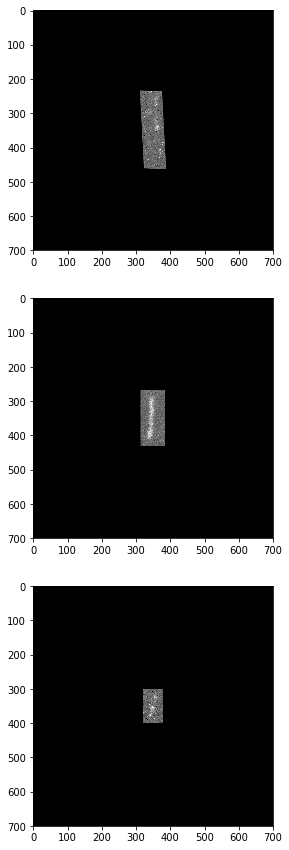

In [13]:
nrows       =  3
ncols       =  1
fig,axes    = plt.subplots(nrows,ncols,figsize=(15,15))


for n in range(1,4):
    name        =  '../../realdata/track_line/' + str(n+15)      ## nome do arquivo    
    img         =  cv2.imread( name +'.png',cv2.IMREAD_GRAYSCALE)      ## le imagem
    axes[n-1].imshow(img,cmap = "gray")
#img1 = 
#img2 =
#img3 = 
#axes.imshow()